In [1]:
# Automatically reload modules
%load_ext autoreload
%autoreload 2


In [2]:
import torch
from hmpinn.utils.ml_utils import train
from hmpinn.models import ModelV1
from hmpinn.plotting import plot_errors_in_grid, plot_errors_from_data
import torch.nn as nn

import seaborn as sns
#Setting theme
sns.set_theme(style="whitegrid")

# Set seed
torch.manual_seed(0)


In [3]:
from hmpinn.PDEs import EigenfunctionSourceDF
eigenfunction = EigenfunctionSourceDF()
from hmpinn.PDEs import InhomoBCDF
func = InhomoBCDF()

In [4]:
class ModelV1_no_embedding(nn.Module):
    def __init__(self,
                 poi_equation,
                 nodes_hidden_layers = [64, 64, 64, 64, 64, 64],
                 embedding_size_per_dim = 2):
        super().__init__()
        self.embedding_size_per_dim = embedding_size_per_dim
        self.has_embedding_layer = False
        self.PDE = poi_equation

        #Create a list with sizes of the layers
        self.nodes = [2] + nodes_hidden_layers + [1]
        self.numb_layers = len(self.nodes)

        #Start constructing the network
        self.network = nn.Sequential()
        
        #All layers
        for i in range(0, self.numb_layers-1):
            self.network.add_module("layer_" + str(i), nn.Linear(self.nodes[i], self.nodes[i+1]))

            #Add all the activations except for the output layer
            if i != self.numb_layers-2:
                self.network.add_module("tanh_" + str(i), nn.Tanh())
        
        #Initialise
        self.initialise_weights()
        
    #Forward pass
    def forward(self, x):
        #If we are training, we need to compute the embedding layer
        if self.training:
            return self.network(x)
              
        #If we are not training, we can use the embedding layer and subtract the value of the network at zero
        else:
            return self.network(x) - \
                    self.network(torch.zeros_like(x)) + \
                    self.poisson_equation.boundary_value
    
    #Initialize the weights of the network as suggested by Xavier Glorot Yoshua Bengio (2010)
    def initialise_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

In [5]:
model_emb = ModelV1(func, [20,20,20,20])
model_no_emb = ModelV1_no_embedding(func, [20,20,20,20])

# Using the Adam optimizer

## With embedding layer

Using Cuda
Solving the PDE: InhomoBCDF(backend=torch)


  0%|          | 0/950 [00:00<?, ?it/s]e:\ProgramFiles\envs\PINN_env\lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


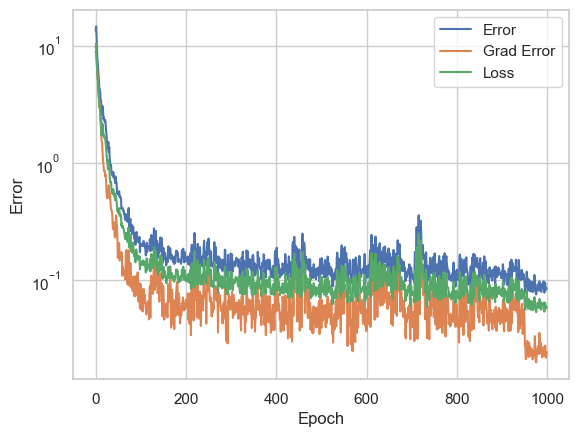

In [6]:
model_emb.train()
errors, grad_errors, loss = train(model_emb, optimizer="Adam", optimizer_threshold=950, n_epochs=1000, save_BC_loss=False)
plot_errors_from_data(errors, grad_errors, loss)

## Without embedding layer

Using Cuda
Solving the PDE: InhomoBCDF(backend=torch)


100%|██████████| 50/50 [00:23<00:00,  2.11it/s]


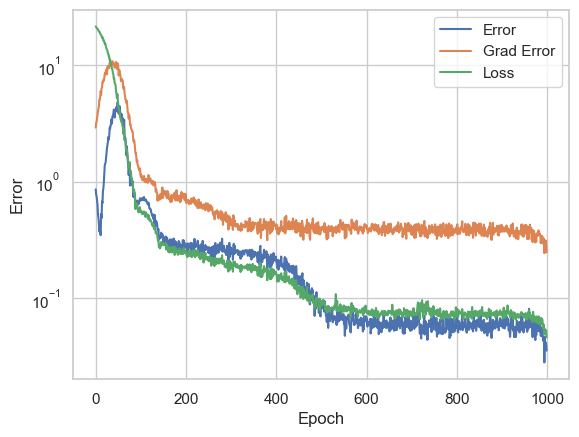

In [7]:
model_no_emb.train()
errors, grad_errors, loss = train(model_no_emb, optimizer="Adam", optimizer_threshold=950, n_epochs=1000, save_BC_loss=False)
plot_errors_from_data(errors, grad_errors, loss)

# Using SGD

In [8]:
model_emb = ModelV1(func, [20,20,20,20])
model_no_emb = ModelV1_no_embedding(func, [20,20,20,20])

## With embedding layer

Using Cuda
Solving the PDE: InhomoBCDF(backend=torch)


100%|██████████| 50/50 [00:35<00:00,  1.43it/s]


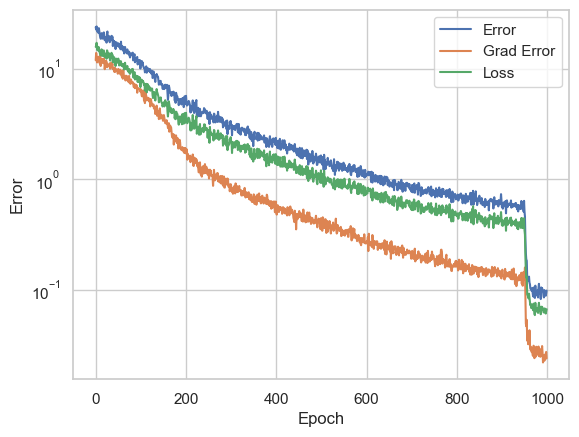

In [9]:
model_emb.train()
errors, grad_errors, loss = train(model_emb, optimizer="SGD", optimizer_threshold=950, n_epochs=1000, save_BC_loss=False)
plot_errors_from_data(errors, grad_errors, loss)

## Without embedding layer

Using Cuda
Solving the PDE: InhomoBCDF(backend=torch)


100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


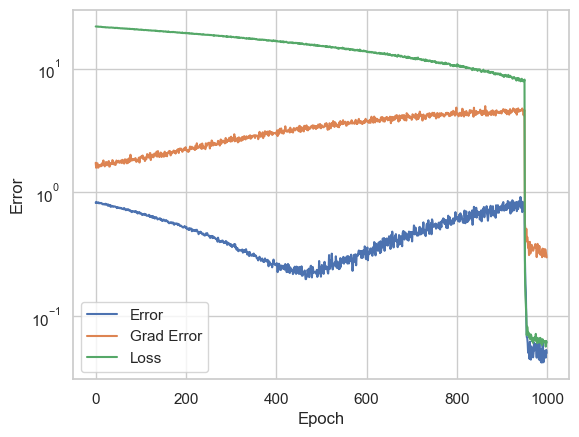

In [10]:
model_no_emb.train()
errors, grad_errors, loss = train(model_no_emb, optimizer="SGD", optimizer_threshold=950, n_epochs=1000, save_BC_loss=False)
plot_errors_from_data(errors, grad_errors, loss)

# Adam

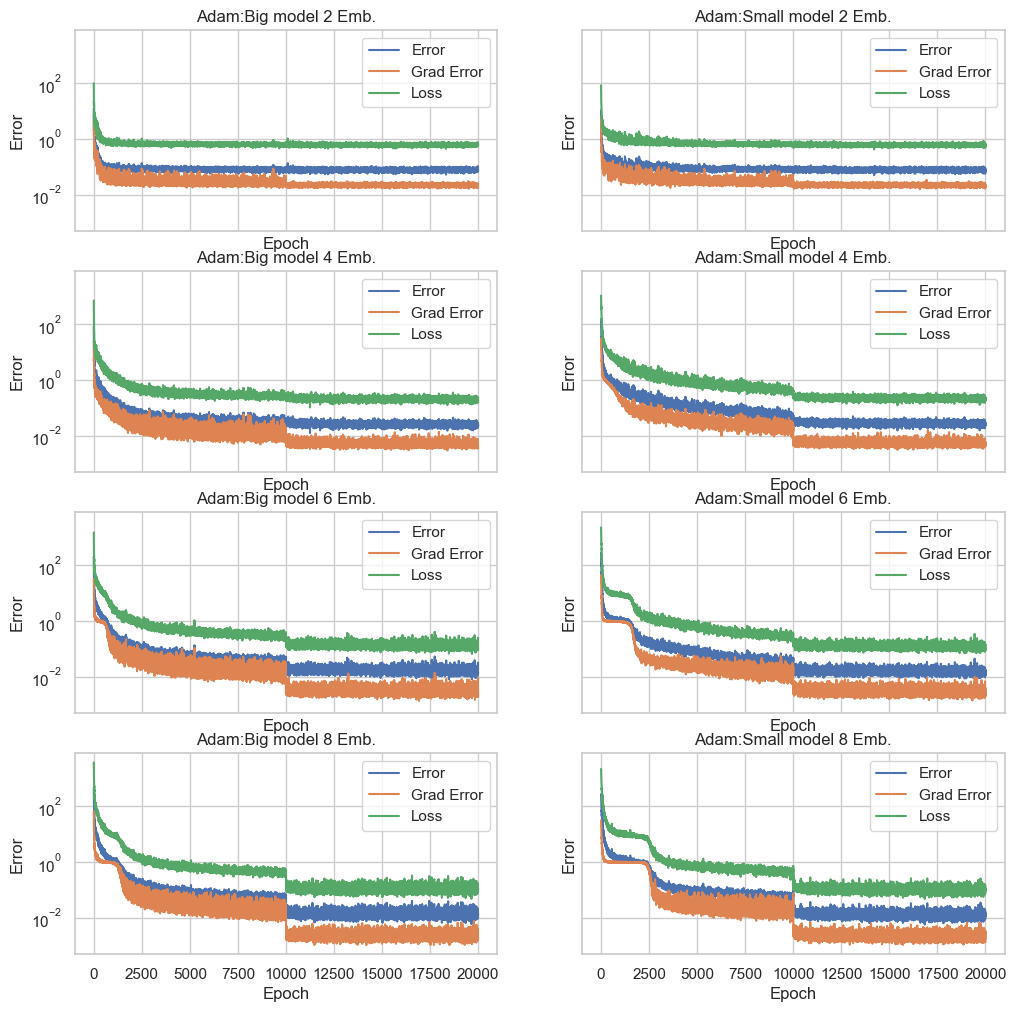

In [11]:
path_list = [
    "../simulation_studies/model_v1_simulation/outputs/2 emb_[64, 64, 64, 64, 64, 64]_poly_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/2 emb_[20, 20, 20, 20]_poly_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/4 emb_[64, 64, 64, 64, 64, 64]_poly_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/4 emb_[20, 20, 20, 20]_poly_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/6 emb_[64, 64, 64, 64, 64, 64]_poly_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/6 emb_[20, 20, 20, 20]_poly_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/8 emb_[64, 64, 64, 64, 64, 64]_poly_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/8 emb_[20, 20, 20, 20]_poly_Adam_10000",

]
title_list = ["Adam:Big model 2 Emb." , "Adam:Small model 2 Emb.",
            "Adam:Big model 4 Emb." , "Adam:Small model 4 Emb.",
            "Adam:Big model 6 Emb." , "Adam:Small model 6 Emb.",
            "Adam:Big model 8 Emb." , "Adam:Small model 8 Emb."]

plot_errors_in_grid(path_list, number_of_rows=4, number_of_columns=2, title_list=title_list)

# SGD

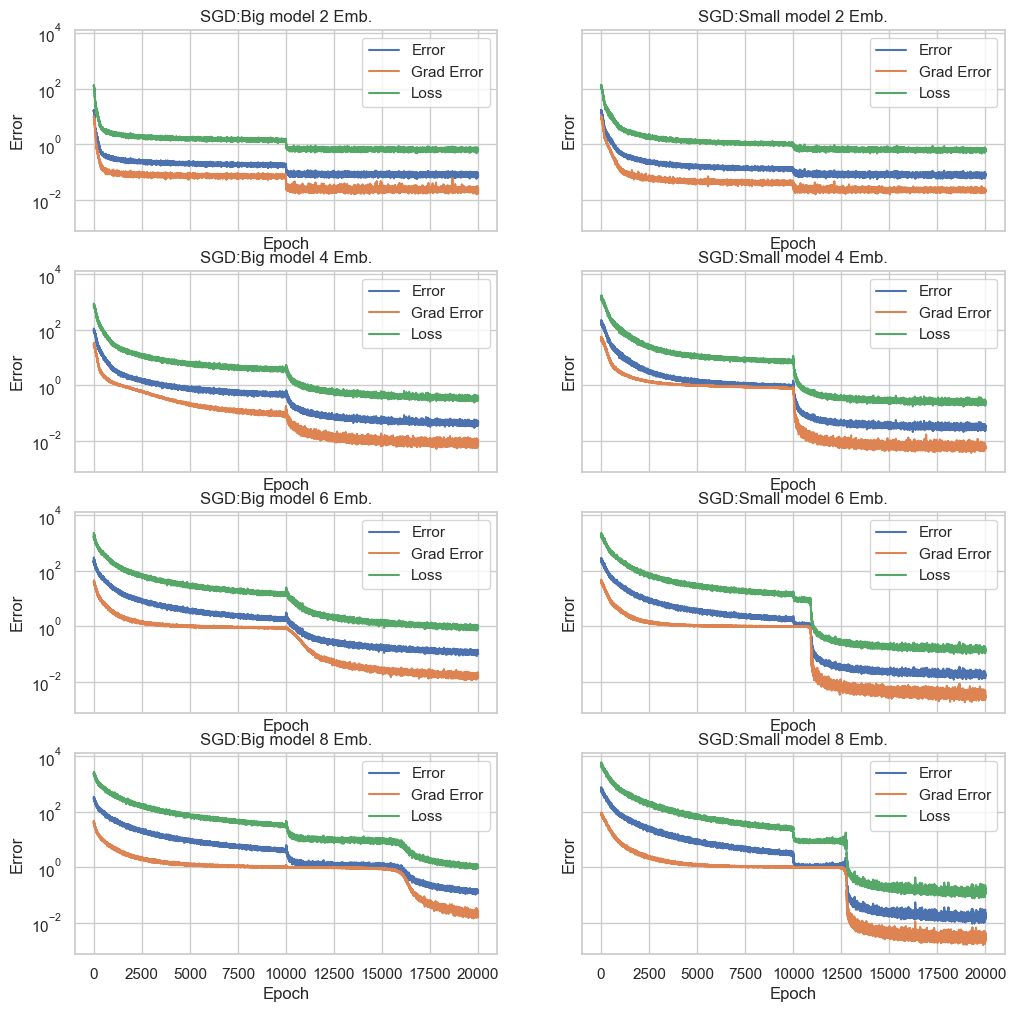

In [12]:
path_list = [
    "../simulation_studies/model_v1_simulation/outputs/2 emb_[64, 64, 64, 64, 64, 64]_poly_SGD_10000",
    "../simulation_studies/model_v1_simulation/outputs/2 emb_[20, 20, 20, 20]_poly_SGD_10000",
    "../simulation_studies/model_v1_simulation/outputs/4 emb_[64, 64, 64, 64, 64, 64]_poly_SGD_10000",
    "../simulation_studies/model_v1_simulation/outputs/4 emb_[20, 20, 20, 20]_poly_SGD_10000",
    "../simulation_studies/model_v1_simulation/outputs/6 emb_[64, 64, 64, 64, 64, 64]_poly_SGD_10000",
    "../simulation_studies/model_v1_simulation/outputs/6 emb_[20, 20, 20, 20]_poly_SGD_10000",
    "../simulation_studies/model_v1_simulation/outputs/8 emb_[64, 64, 64, 64, 64, 64]_poly_SGD_10000",
    "../simulation_studies/model_v1_simulation/outputs/8 emb_[20, 20, 20, 20]_poly_SGD_10000",

]
title_list = ["SGD:Big model 2 Emb." , "SGD:Small model 2 Emb.",
            "SGD:Big model 4 Emb." , "SGD:Small model 4 Emb.",
            "SGD:Big model 6 Emb." , "SGD:Small model 6 Emb.",
            "SGD:Big model 8 Emb." , "SGD:Small model 8 Emb."]

plot_errors_in_grid(path_list, number_of_rows=4, number_of_columns=2, title_list=title_list)

# Eigenfunction problem

## Change optimizer early

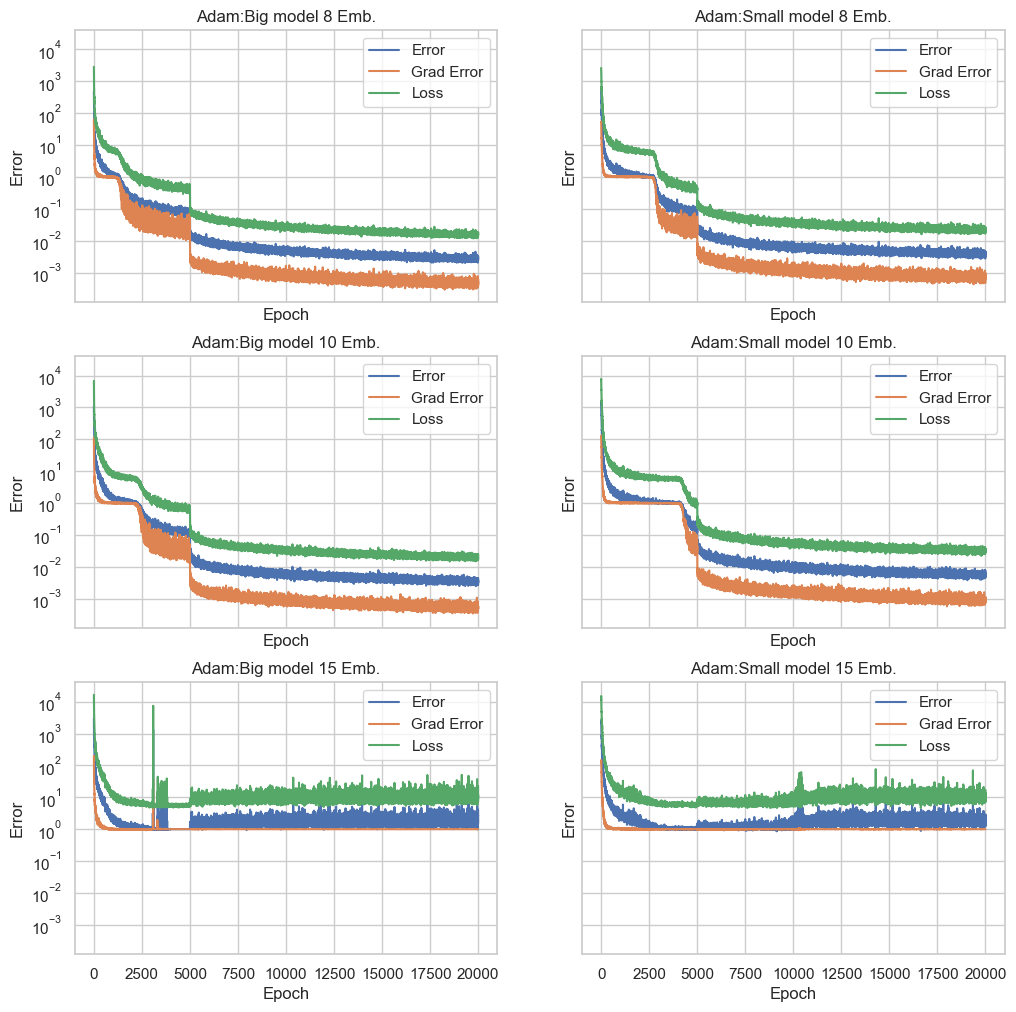

In [13]:
path_list = [
    "../simulation_studies/model_v1_simulation/outputs/8 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_5000",
    "../simulation_studies/model_v1_simulation/outputs/8 emb_[20, 20, 20, 20]_eigenfunc_Adam_5000",
    "../simulation_studies/model_v1_simulation/outputs/10 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_5000",
    "../simulation_studies/model_v1_simulation/outputs/10 emb_[20, 20, 20, 20]_eigenfunc_Adam_5000",
    "../simulation_studies/model_v1_simulation/outputs/15 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_5000",
    "../simulation_studies/model_v1_simulation/outputs/15 emb_[20, 20, 20, 20]_eigenfunc_Adam_5000",

]
title_list = [
            "Adam:Big model 8 Emb." , "Adam:Small model 8 Emb.",
            "Adam:Big model 10 Emb." , "Adam:Small model 10 Emb.",
            "Adam:Big model 15 Emb." , "Adam:Small model 15 Emb.",]


plot_errors_in_grid(path_list, number_of_rows=3, number_of_columns=2, title_list=title_list)

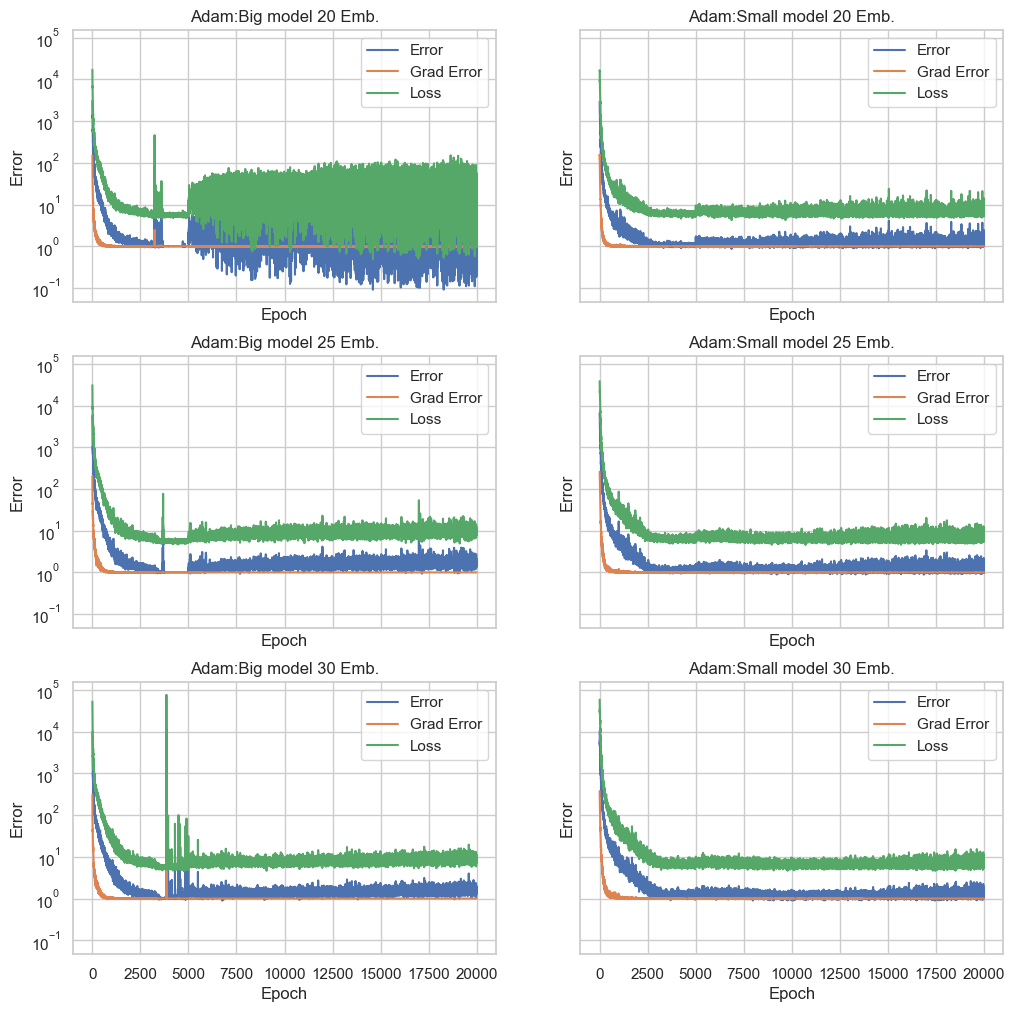

In [14]:
path_list = [
    "../simulation_studies/model_v1_simulation/outputs/20 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_5000",
    "../simulation_studies/model_v1_simulation/outputs/20 emb_[20, 20, 20, 20]_eigenfunc_Adam_5000",
    "../simulation_studies/model_v1_simulation/outputs/25 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_5000",
    "../simulation_studies/model_v1_simulation/outputs/25 emb_[20, 20, 20, 20]_eigenfunc_Adam_5000",
    "../simulation_studies/model_v1_simulation/outputs/30 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_5000",
    "../simulation_studies/model_v1_simulation/outputs/30 emb_[20, 20, 20, 20]_eigenfunc_Adam_5000",

]
title_list = [
            "Adam:Big model 20 Emb." , "Adam:Small model 20 Emb.",
            "Adam:Big model 25 Emb." , "Adam:Small model 25 Emb.",
            "Adam:Big model 30 Emb." , "Adam:Small model 30 Emb."]


plot_errors_in_grid(path_list, number_of_rows=3, number_of_columns=2, title_list=title_list)

## Change optimizer mid way

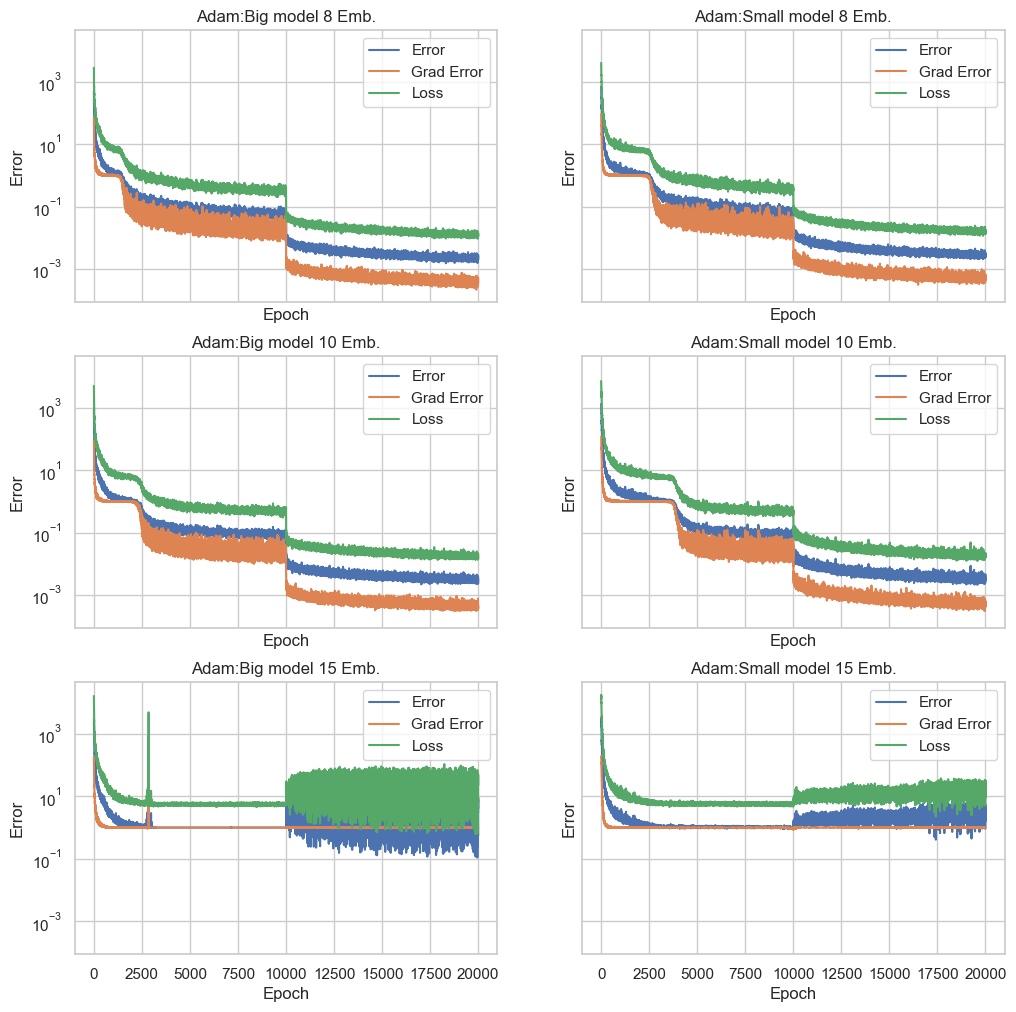

In [15]:
path_list = [
    "../simulation_studies/model_v1_simulation/outputs/8 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/8 emb_[20, 20, 20, 20]_eigenfunc_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/10 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/10 emb_[20, 20, 20, 20]_eigenfunc_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/15 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/15 emb_[20, 20, 20, 20]_eigenfunc_Adam_10000",

]
title_list = [
            "Adam:Big model 8 Emb." , "Adam:Small model 8 Emb.",
            "Adam:Big model 10 Emb." , "Adam:Small model 10 Emb.",
            "Adam:Big model 15 Emb." , "Adam:Small model 15 Emb."]


plot_errors_in_grid(path_list, number_of_rows=3, number_of_columns=2, title_list=title_list)

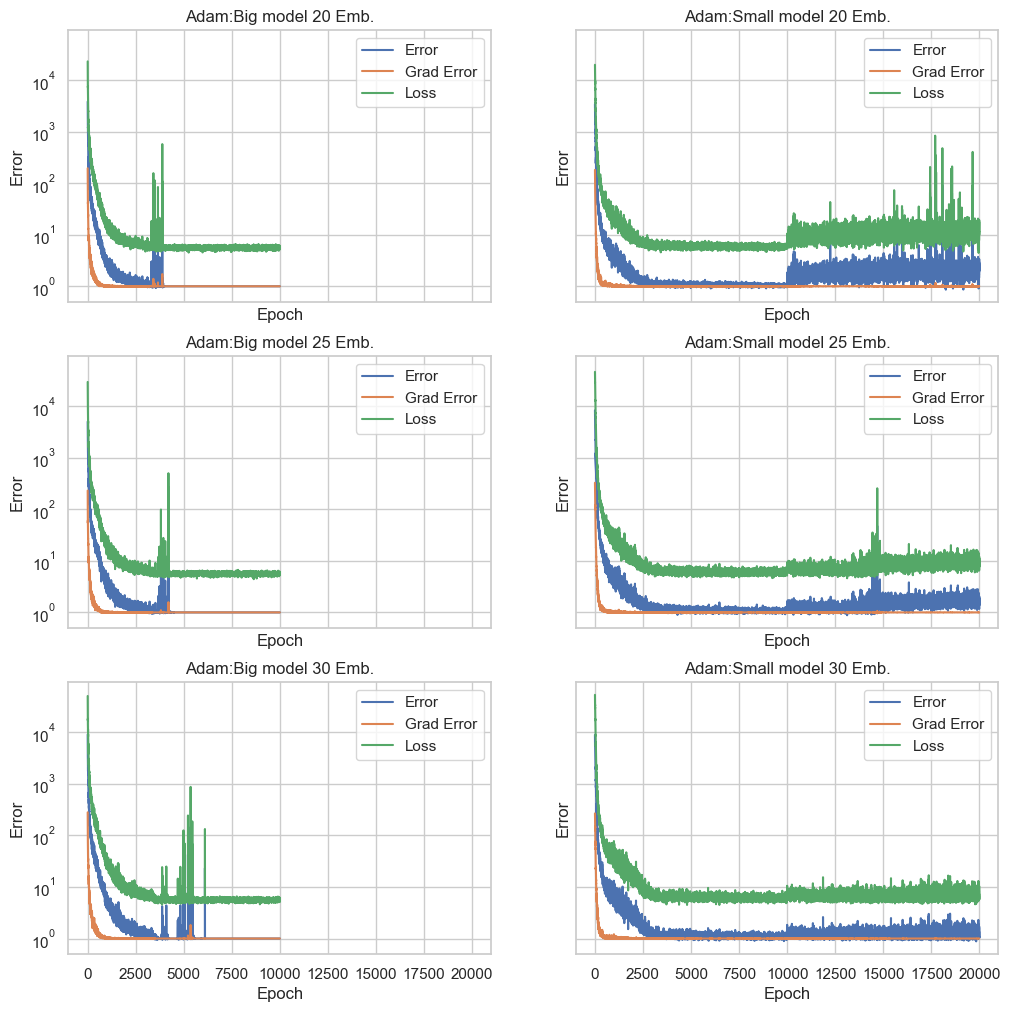

In [16]:
path_list = [

    "../simulation_studies/model_v1_simulation/outputs/20 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/20 emb_[20, 20, 20, 20]_eigenfunc_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/25 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/25 emb_[20, 20, 20, 20]_eigenfunc_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/30 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/30 emb_[20, 20, 20, 20]_eigenfunc_Adam_10000",

]
title_list = [
            "Adam:Big model 20 Emb." , "Adam:Small model 20 Emb.",
            "Adam:Big model 25 Emb." , "Adam:Small model 25 Emb.",
            "Adam:Big model 30 Emb." , "Adam:Small model 30 Emb."]


plot_errors_in_grid(path_list, number_of_rows=3, number_of_columns=2, title_list=title_list)

## Change optimizer late

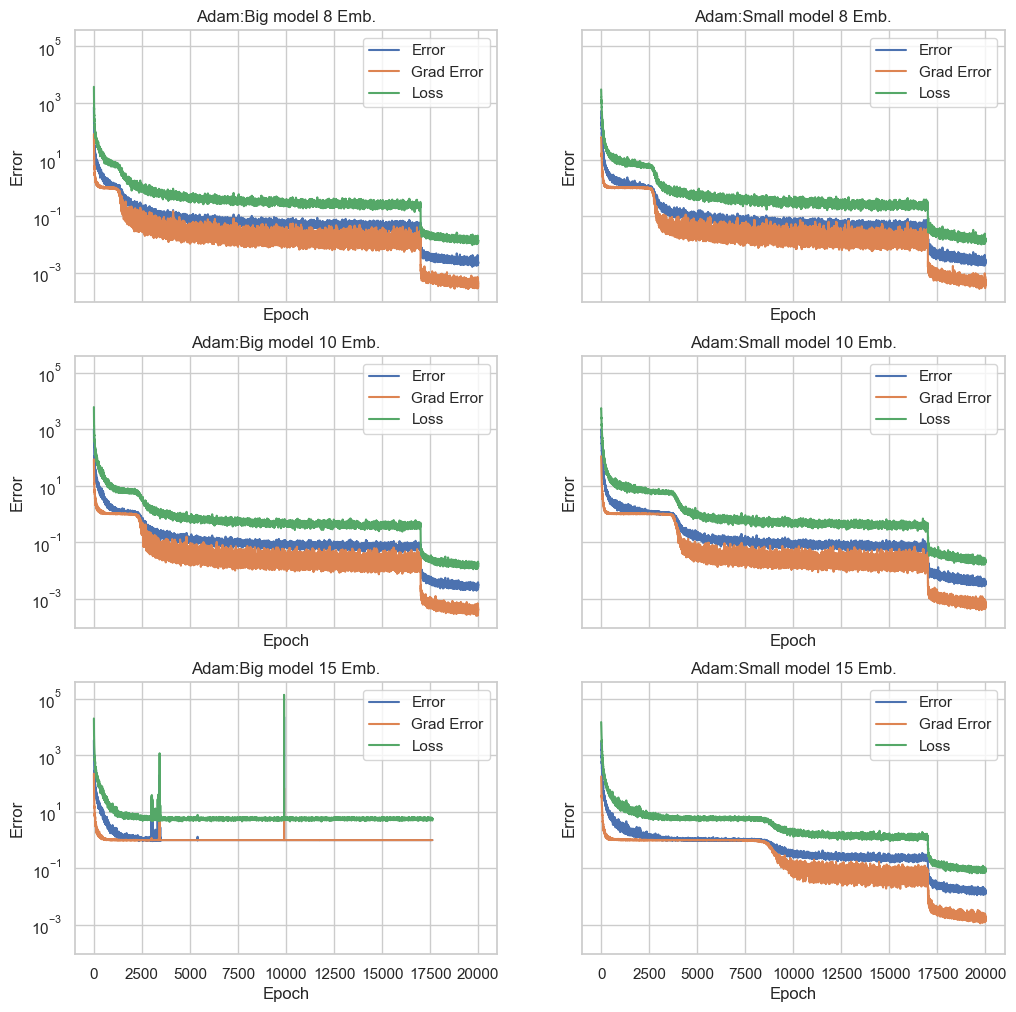

In [17]:
path_list = [
    "../simulation_studies/model_v1_simulation/outputs/8 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_17000",
    "../simulation_studies/model_v1_simulation/outputs/8 emb_[20, 20, 20, 20]_eigenfunc_Adam_17000",
    "../simulation_studies/model_v1_simulation/outputs/10 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_17000",
    "../simulation_studies/model_v1_simulation/outputs/10 emb_[20, 20, 20, 20]_eigenfunc_Adam_17000",
    "../simulation_studies/model_v1_simulation/outputs/15 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_17000",
    "../simulation_studies/model_v1_simulation/outputs/15 emb_[20, 20, 20, 20]_eigenfunc_Adam_17000",
]
title_list = [
            "Adam:Big model 8 Emb." , "Adam:Small model 8 Emb.",
            "Adam:Big model 10 Emb." , "Adam:Small model 10 Emb.",
            "Adam:Big model 15 Emb." , "Adam:Small model 15 Emb.",
            ]


plot_errors_in_grid(path_list, number_of_rows=3, number_of_columns=2, title_list=title_list)

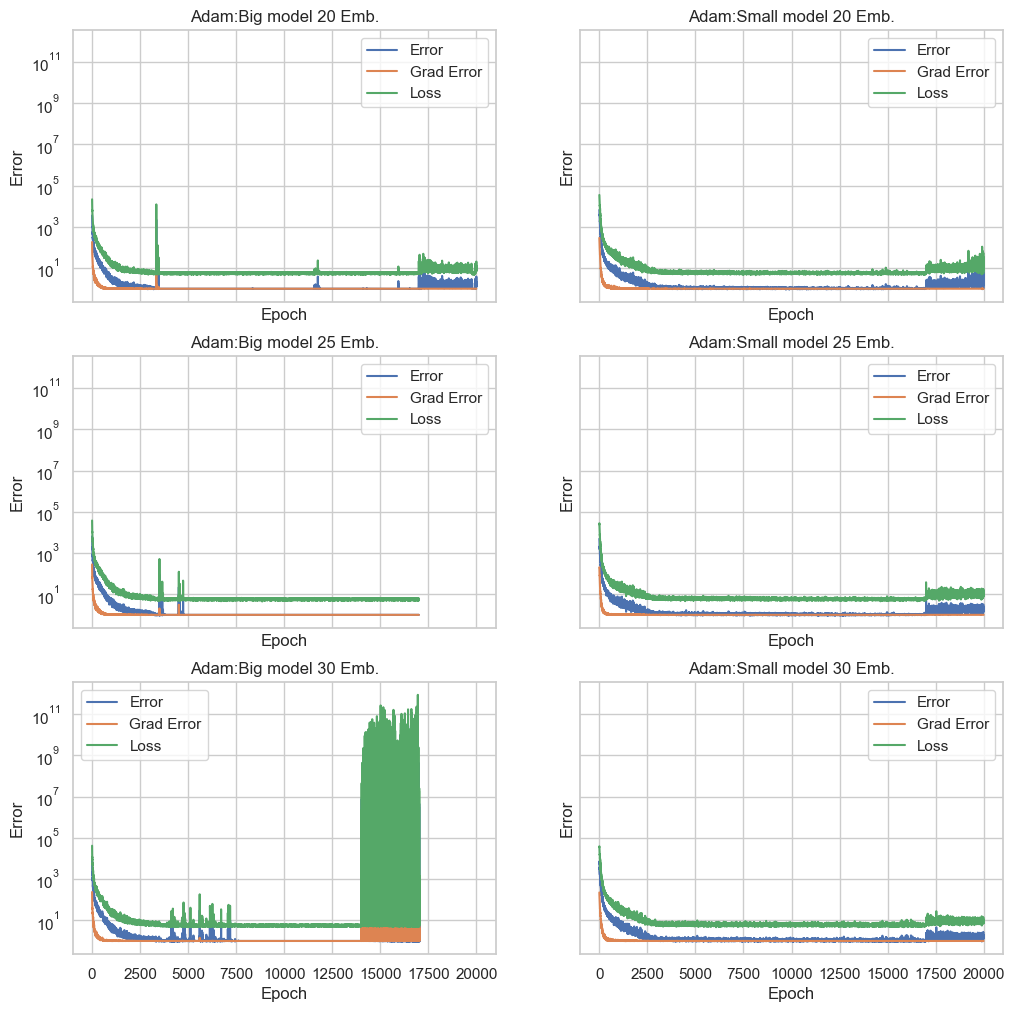

In [18]:
path_list = [
    "../simulation_studies/model_v1_simulation/outputs/20 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_17000",
    "../simulation_studies/model_v1_simulation/outputs/20 emb_[20, 20, 20, 20]_eigenfunc_Adam_17000",
    "../simulation_studies/model_v1_simulation/outputs/25 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_17000",
    "../simulation_studies/model_v1_simulation/outputs/25 emb_[20, 20, 20, 20]_eigenfunc_Adam_17000",
    "../simulation_studies/model_v1_simulation/outputs/30 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_17000",
    "../simulation_studies/model_v1_simulation/outputs/30 emb_[20, 20, 20, 20]_eigenfunc_Adam_17000",

]
title_list = [
            "Adam:Big model 20 Emb." , "Adam:Small model 20 Emb.",
            "Adam:Big model 25 Emb." , "Adam:Small model 25 Emb.",
            "Adam:Big model 30 Emb." , "Adam:Small model 30 Emb."
            ]


plot_errors_in_grid(path_list, number_of_rows=3, number_of_columns=2, title_list=title_list)